## author: Virginia Ordoño Bernier
## date: december 2023


## Prácticas Naive Bayes y KNN (ejercicio 1)

#### **1. Tomando como base este [tutorial](https://colab.research.google.com/drive/1zFIOfrceEaFkhQOEOkMWroBmNV1HAMVS?usp=drive_link),  crea un modelo de clasificación usando KNN con los mismos datos sintéticos. Para la elección de los mejores hiperparámetros usa un sistema de [validación cruzada](https://educacionadistancia.juntadeandalucia.es/centros/cordoba/pluginfile.php/406946/mod_resource/content/1/M2_SAA_S10%20-%20Validaci%C3%B3n.pdf).**

#### 2. Usando los datos almacenados en data2.csv, crea un modelo de clasificación usando los modelos de NaiveBayes mostrados en el [vídeo 5](https://vimeo.com/600140324). Indicad qué modelo da mejores resultados. Os toca investigar cómo cargar un archivo csv desde Google Collab.

#### 3. En este [enlace](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) puedes descargar un dataset que recoge diferentes características de vino rojo portugués "Vinho Verde" y la calidad del mismo. Crea un modelo de clasificación usando NaiveBayes (GaussianNB) y KNN.

#### 4. Plantea el problema anterior con un modelo de regresión usando KNN. En el [vídeo 7](https://vimeo.com/600141357) hay un ejemplo de regresión con KNN.

#### 1. Generación de datos sintéticos


In [54]:
import numpy as np

np.random.seed(41)

# Clase 0. Distribución normal de media 0 y desviación estándar 1
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) # Representación de etiquetas como ceros

# Clase 1. Distribución normal de media 3 y desviación estándar 1
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) # Representación de etiquetas como unos

In [55]:
import pandas as pd

# Formateo de datos
X = np.vstack((class_0_data, class_1_data)) # Une dos matrices en una en forma de pila
y = np.concatenate((class_0_labels, class_1_labels)) # Concatena las matrices de los nombres en una en forma de columna

# Creación del dataset
df_classes = pd.concat([pd.DataFrame(X, columns=['class_0', 'class_1']) ,  pd.DataFrame(y, columns=['target'])], axis=1)

# Clase target solo con enteros
df_classes.target = df_classes.target.astype(int)

df_classes

,class_0,class_1,target
0,-0.270712,0.104848,0
1,0.250528,-0.925200,0
2,0.567144,-1.040180,0
3,-0.153676,0.789852,0
4,-1.226216,-0.948007,0
...,...,...,...
195,3.754550,4.091037,1
196,3.957150,3.399005,1
197,1.118678,2.318888,1
198,4.010052,3.822308,1


#### 2. Carga de datos

In [56]:
# Comprobamos valores de la columna Label
df_classes['target'].unique()

array([0, 1])

#### 3. Selección de variables
Para realizar esta selección vamos a utilizar la correlación entre cada una de las características y la variable a predecir.


,class_0,class_1,target
class_0,1.000000,0.711657,0.810961
class_1,0.711657,1.000000,0.861755
target,0.810961,0.861755,1.000000


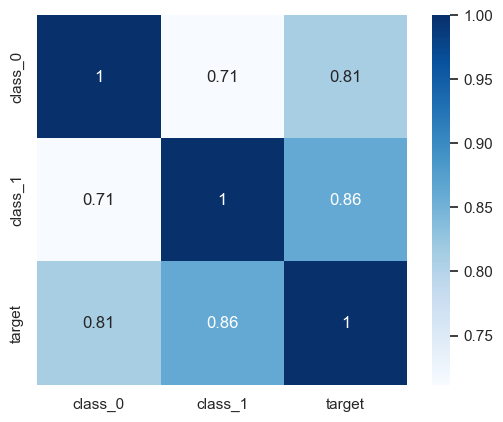

In [57]:
import seaborn as sns

sns.set()
sns.heatmap(df_classes.corr(), square=True, annot=True, cmap='Blues')

# Las variables con una correlación cercana a 1 tienen una correlación positiva fuerte, 
# Las variables con una correlación cercana a -1 tienen una correlación negativa fuerte. 
# Si la correlación está cerca de 0, las variables están débilmente correlacionadas.
# En este caso no sería necesario puesto que la correlación es cercana a 0.

df_classes.corr()

#### 4. Parametrización KNN y Validación Cruzada


In [58]:
from sklearn.model_selection import train_test_split

# División el conjunto de datos en train y test en un porcentaje de 2/3 vs 1/3
train, test = train_test_split(df_classes[['class_0','class_1', 'target']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
train

,index,class_0,class_1,target
0,8,-0.609778,1.469416,0
1,19,-0.818308,-0.962384,0
2,138,1.548087,3.921564,1
3,173,4.853147,5.114540,1
4,185,2.514818,2.385031,1
...,...,...,...,...
129,90,-1.234605,1.470797,0
130,121,1.607519,3.988415,1
131,155,4.514982,3.480295,1
132,133,2.853887,1.907700,1


Máximo valor de precisión para pesos "uniform": 1.0 (Número de vecinos: 1)
Máximo valor de precisión para pesos "distance": 1.0 (Número de vecinos: 1)


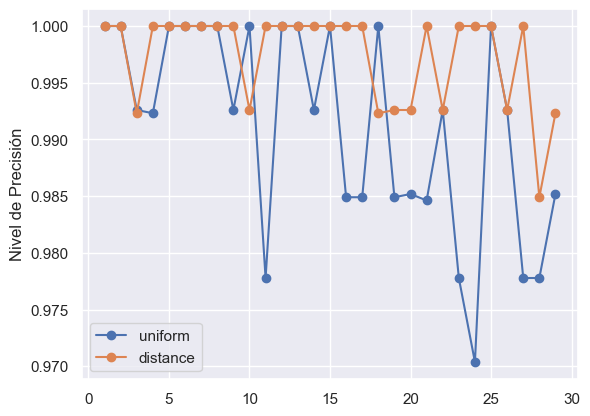

In [59]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluación del rendimiento de un clasificador K-Nearest Neighbors (KNN) con diferentes parámetros.

cv = KFold(n_splits = 5, shuffle = True) # 5 iteraciones de entremiento y evaluación (5 folds). 

# En cada iteración, se dividirán los datos en conjuntos de entrenamiento y prueba.
for i, weights in enumerate(['uniform', 'distance']): # Dos configuraciones: vecinos con mismo peso y pesos inversamente proporcionales a distancia
    
    total_scores = [] # Lista para almacenar los resultados de cada iteración
    
    for n_neighbors in range(1,30):
        fold_accuracy = [] # Lista para almacenar la precisión de cada fold
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        
        for train_fold, test_fold in cv.split(train): # Bucle para la CV
            
            # División de datos según índices obtenidos en la CV
            f_train = train.loc[train_fold]
            f_test = train.loc[test_fold]
            
            # Entrenamiento del modelo
            knn.fit( X = f_train.drop(['target'], axis=1),
                            y = f_train['target'])
            
            # Predicción de los datos de prueba
            y_pred = knn.predict(X = f_test.drop(['target'], axis = 1))
            
            # Evaluación del modelo
            acc = accuracy_score(f_test['target'], y_pred)
            
            # Almacenamiento de la precisión de cada fold
            fold_accuracy.append(acc)

        # Almacenamiento del cálculo del Promedio de Precisión por Vecino:    
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
        # total_scores.append(np.mean(fold_accuracy)) otra opción de cálculo del promedio de precisión por vecino.	
        
    plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
    
    #print ('Máximo valor de precisión para pesos ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
    print(f'Máximo valor de precisión para pesos "{weights}": {max(total_scores)} (Número de vecinos: {np.argmax(total_scores) + 1})')
    plt.ylabel('Nivel de Precisión')

plt.legend()
plt.show()

#### 5a. Clasificador K-Nearest Neighbors (KNN) con Distance

In [63]:
# En las predicciones, los vecinos más cercanos tendrán un peso inversamente proporcional a su distancia.

# Configuración de hiperparámetros
n_neighbors = 3 # Cuanto menos vecinos, más generaliza
weights = 'distance'

# Configuración del clasificador KNN
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)

# Entrenamiento del clasificador KNN
knn.fit(X = train[['class_0','class_1']], y = train['target'])

# Predicción de los datos de test
y_pred = knn.predict(X = test[['class_0','class_1']])

# Evaluación del modelo
acc = accuracy_score(test['target'], y_pred)
print(f'La precisión del modelo KNN con {n_neighbors} vecinos y pesos "{weights}" es: {acc:.4f}')


La precisión del modelo KNN con 3 vecinos y pesos "distance" es: 0.9394


### 6. Visualización

#### 6.1. Matriz de Confusión

c:\Users\Virginia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


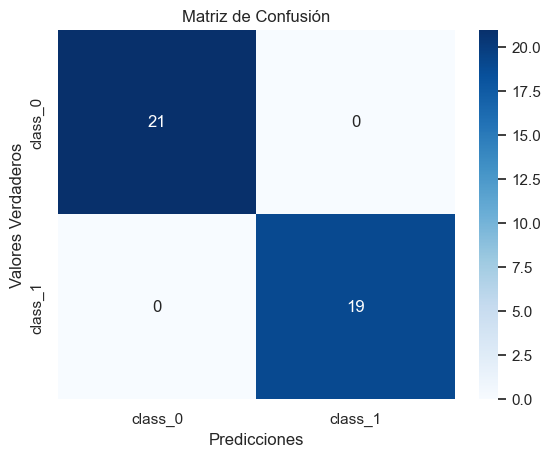

In [62]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predicción de los datos de prueba después de entrenar el modelo
y_pred = knn.predict(X_test)

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
classes = ('class_0', 'class_1')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()
